In [1]:
library(tidyverse) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
library(tidyverse) # general
library(countrycode) # continent
library(rworldmap) # quick country-level heat maps
library(gridExtra) # plots
library(broom)

Loading required package: sp
### Welcome to rworldmap ###
For a short introduction type : 	 vignette('rworldmap')

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [3]:
ensureCranPkg <- function(pkg) {
  if(!suppressWarnings(requireNamespace(pkg, quietly = TRUE))) {
    install.packages(pkg)
  }
}

In [4]:
ensureCranPkg("ggalt")
ensureCranPkg("tidyverse")
ensureCranPkg("countrycode")
ensureCranPkg("rworldmap")
ensureCranPkg("gridExtra")

Installing package into ‘/home/anand/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
also installing the dependency ‘proj4’

Warning message in install.packages(pkg):
“installation of package ‘proj4’ had non-zero exit status”Warning message in install.packages(pkg):
“installation of package ‘ggalt’ had non-zero exit status”

In [5]:
data <- read_csv("datasets/this_is_only_for_reference.csv")

Parsed with column specification:
cols(
  country = col_character(),
  year = col_double(),
  sex = col_character(),
  age = col_character(),
  suicides_no = col_double(),
  population = col_double(),
  `suicides/100k pop` = col_double(),
  `country-year` = col_character(),
  `HDI for year` = col_double(),
  `gdp_for_year ($)` = col_number(),
  `gdp_per_capita ($)` = col_double(),
  generation = col_character()
)


In [6]:
data <- data %>% 
  select(-c(`HDI for year`, `suicides/100k pop`)) %>%
  rename(gdp_for_year = `gdp_for_year ($)`, 
         gdp_per_capita = `gdp_per_capita ($)`, 
         country_year = `country-year`) %>%
  as.data.frame()

In [7]:
data <- data %>%
  filter(year != 2016) %>% # I therefore exclude 2016 data
  select(-country_year)

In [8]:
minimum_years <- data %>%
  group_by(country) %>%
  summarize(rows = n(), 
            years = rows / 12) %>%
  arrange(years)

data <- data %>%
  filter(!(country %in% head(minimum_years$country, 7)))

In [9]:
library(countrycode)

In [10]:
data$age <- gsub(" years", "", data$age)
data$sex <- ifelse(data$sex == "male", "Male", "Female")


# getting continent data:
data$continent <- countrycode(sourcevar = data[, "country"],
                              origin = "country.name",
                              destination = "continent")

# Nominal factors
data_nominal <- c('country', 'sex', 'continent')
data[data_nominal] <- lapply(data[data_nominal], function(x){factor(x)})


# Making age ordinal
data$age <- factor(data$age, 
                   ordered = T, 
                   levels = c("5-14",
                              "15-24", 
                              "25-34", 
                              "35-54", 
                              "55-74", 
                              "75+"))

# Making generation ordinal
data$generation <- factor(data$generation, 
                   ordered = T, 
                   levels = c("G.I. Generation", 
                              "Silent",
                              "Boomers", 
                              "Generation X", 
                              "Millenials", 
                              "Generation Z"))

data <- as_tibble(data)


# the global rate over the time period will be useful:

global_average <- (sum(as.numeric(data$suicides_no)) / sum(as.numeric(data$population))) * 100000

In [11]:
continent <- data %>%
  group_by(continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  arrange(suicide_per_100k)

continent$continent <- factor(continent$continent, ordered = T, levels = continent$continent)

continent_plot <- ggplot(continent, aes(x = continent, y = suicide_per_100k, fill = continent)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Global Suicides (per 100k), by Continent",
  x = "Continent", 
  y = "Suicides per 100k", 
  fill = "Continent") +
  theme(legend.position = "none", title = element_text(size = 10)) + 
  scale_y_continuous(breaks = seq(0, 20, 1), minor_breaks = F)

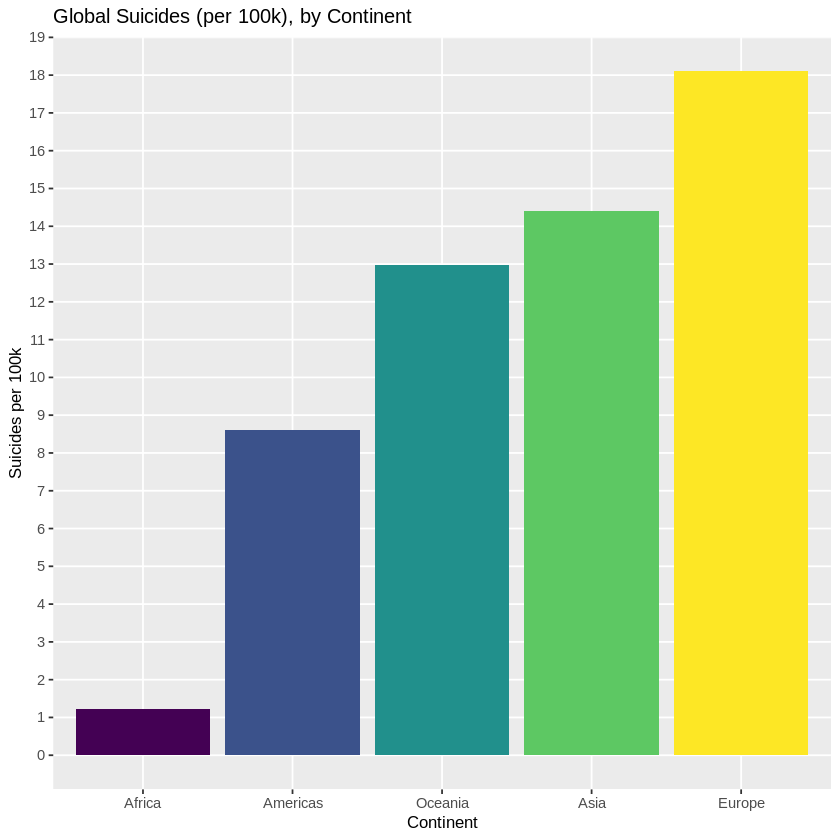

In [12]:
continent_plot

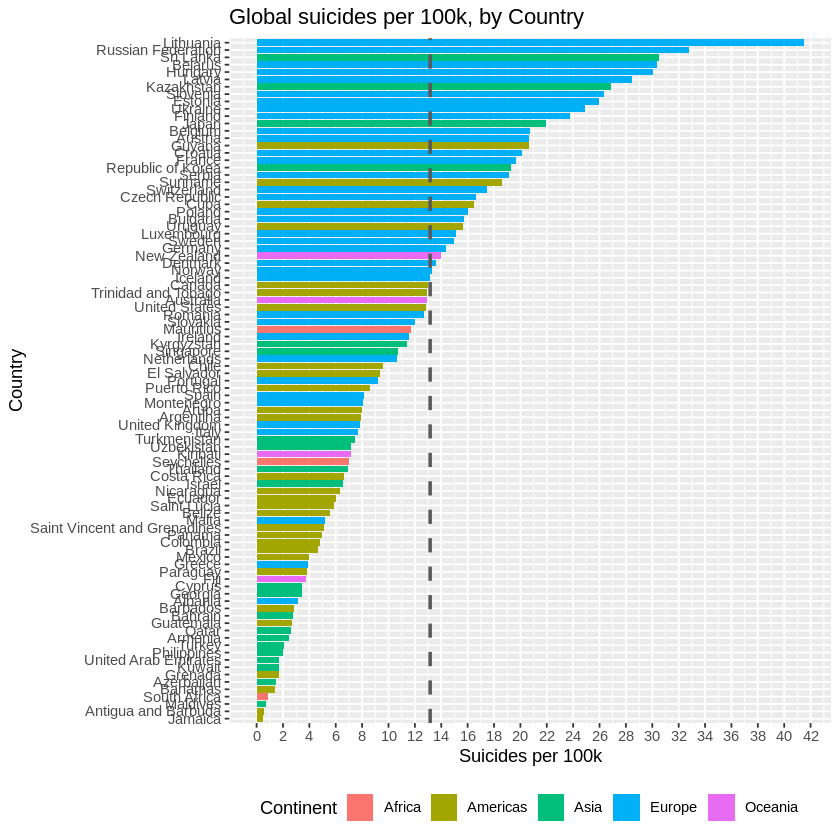

In [13]:
country <- data %>%
  group_by(country, continent) %>%
  summarize(n = n(), 
            suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  arrange(desc(suicide_per_100k))

country$country <- factor(country$country, 
                          ordered = T, 
                          levels = rev(country$country))

ggplot(country, aes(x = country, y = suicide_per_100k, fill = continent)) + 
  geom_bar(stat = "identity") + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Global suicides per 100k, by Country",
       x = "Country", 
       y = "Suicides per 100k", 
       fill = "Continent") +
  coord_flip() +
  scale_y_continuous(breaks = seq(0, 45, 2)) + 
  theme(legend.position = "bottom")

In [14]:
age_plot <- data %>%
  group_by(age) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000) %>%
  ggplot(aes(x = age, y = suicide_per_100k, fill = age)) + 
  geom_bar(stat = "identity") + 
  labs(title = "Global suicides per 100k, by Age",
       x = "Age", 
       y = "Suicides per 100k") +
  theme(legend.position = "none") + 
  scale_y_continuous(breaks = seq(0, 30, 1), minor_breaks = F)

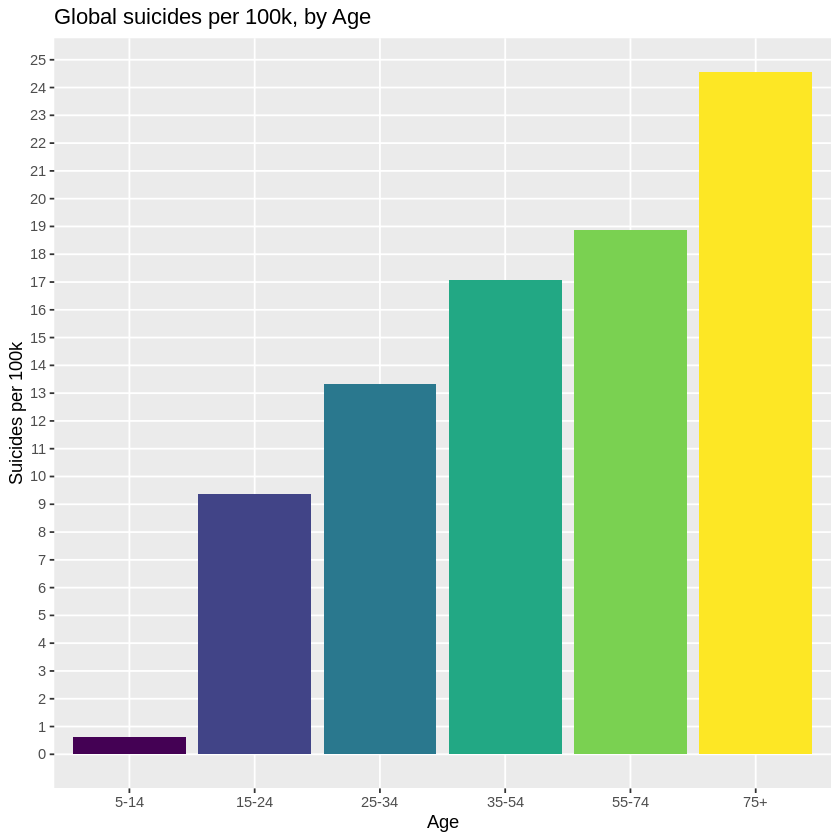

In [15]:
age_plot

In [16]:
glimpse(data)

Observations: 27,492
Variables: 10
$ country        <fct> Albania, Albania, Albania, Albania, Albania, Albania, …
$ year           <dbl> 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987, 1987, …
$ sex            <fct> Male, Male, Female, Male, Male, Female, Female, Female…
$ age            <ord> 15-24, 35-54, 15-24, 75+, 25-34, 75+, 35-54, 25-34, 55…
$ suicides_no    <dbl> 21, 16, 14, 1, 9, 1, 6, 4, 1, 0, 0, 0, 2, 17, 1, 14, 4…
$ population     <dbl> 312900, 308000, 289700, 21800, 274300, 35600, 278800, …
$ gdp_for_year   <dbl> 2156624900, 2156624900, 2156624900, 2156624900, 215662…
$ gdp_per_capita <dbl> 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796,…
$ generation     <ord> Generation X, Silent, Generation X, G.I. Generation, B…
$ continent      <fct> Europe, Europe, Europe, Europe, Europe, Europe, Europe…


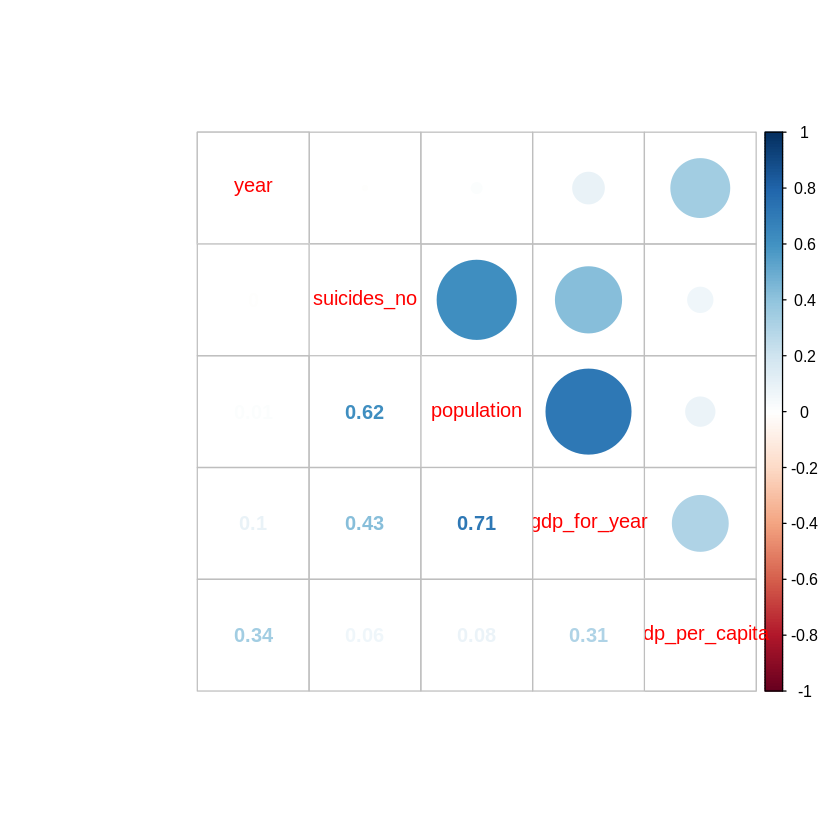

In [22]:
corrplot.mixed(corr = cor(data[,c("year","suicides_no","population","gdp_for_year","gdp_per_capita")]))

In [21]:
library(corrplot)

corrplot 0.84 loaded


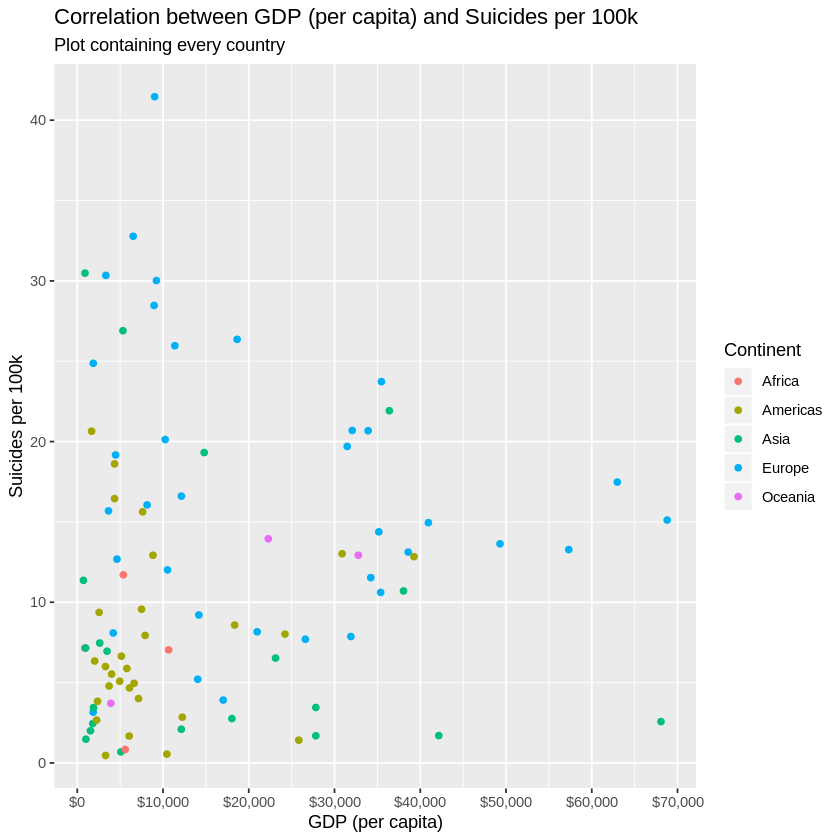

In [23]:
country_mean_gdp <- data %>%
  group_by(country, continent) %>%
  summarize(suicide_per_100k = (sum(as.numeric(suicides_no)) / sum(as.numeric(population))) * 100000, 
            gdp_per_capita = mean(gdp_per_capita))

ggplot(country_mean_gdp, aes(x = gdp_per_capita, y = suicide_per_100k, col = continent)) + 
  geom_point() + 
  scale_x_continuous(labels=scales::dollar_format(prefix="$"), breaks = seq(0, 70000, 10000)) + 
  labs(title = "Correlation between GDP (per capita) and Suicides per 100k", 
       subtitle = "Plot containing every country",
       x = "GDP (per capita)", 
       y = "Suicides per 100k", 
       col = "Continent") 

In [24]:
data

country,year,sex,age,suicides_no,population,gdp_for_year,gdp_per_capita,generation,continent
<fct>,<dbl>,<fct>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<fct>
Albania,1987,Male,15-24,21,312900,2156624900,796,Generation X,Europe
Albania,1987,Male,35-54,16,308000,2156624900,796,Silent,Europe
Albania,1987,Female,15-24,14,289700,2156624900,796,Generation X,Europe
Albania,1987,Male,75+,1,21800,2156624900,796,G.I. Generation,Europe
Albania,1987,Male,25-34,9,274300,2156624900,796,Boomers,Europe
Albania,1987,Female,75+,1,35600,2156624900,796,G.I. Generation,Europe
Albania,1987,Female,35-54,6,278800,2156624900,796,Silent,Europe
Albania,1987,Female,25-34,4,257200,2156624900,796,Boomers,Europe
Albania,1987,Male,55-74,1,137500,2156624900,796,G.I. Generation,Europe


In [25]:
data['gdp_per_capita ($)']

ERROR: Error: Can't find column `gdp_per_capita ($)` in `.data`.


In [26]:
x=data.frame(data['gdp_per_capita ($)'])

ERROR: Error: Can't find column `gdp_per_capita ($)` in `.data`.


In [27]:
y=data.frame(data['suicides/100k pop'])

ERROR: Error: Can't find column `suicides/100k pop` in `.data`.


In [ ]:
plot(x,y,pch=19)

In [28]:
p <- plot(data['gdp_per_capita ($)'],data['suicides/100k pop'],pch=19)
fit <- lm(y~poly(x,2,raw=TRUE)) 
print(p)

ERROR: Error: Can't find column `gdp_per_capita ($)` in `.data`.


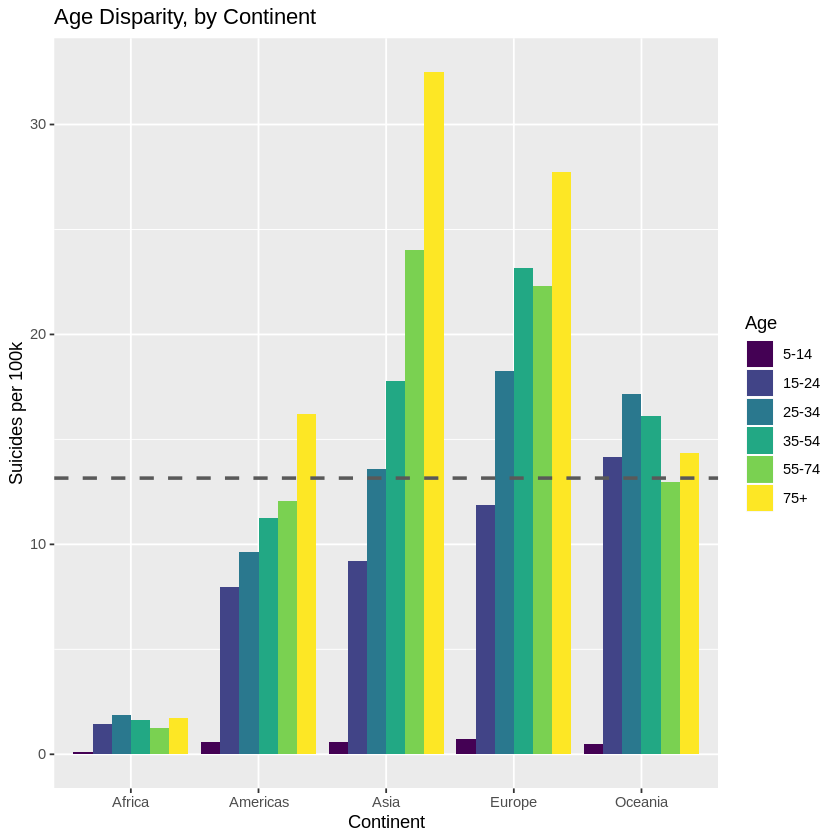

In [29]:
data %>%
  group_by(continent, age) %>%
  summarize(n = n(), 
            suicides = sum(as.numeric(suicides_no)), 
            population = sum(as.numeric(population)), 
            suicide_per_100k = (suicides / population) * 100000) %>%
  ggplot(aes(x = continent, y = suicide_per_100k, fill = age)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  geom_hline(yintercept = global_average, linetype = 2, color = "grey35", size = 1) +
  labs(title = "Age Disparity, by Continent",
       x = "Continent", 
       y = "Suicides per 100k", 
       fill = "Age")

In [30]:
library(tidyr)
library(purrr)

In [31]:
ggplot(gdp_suicide_no_outliers, aes(x = gdp_per_capita, y = suicide_per_100k, col = continent)) + 
  geom_point() + 
  geom_smooth(method = "lm", aes(group = 1)) + 
  scale_x_continuous(labels=scales::dollar_format(prefix="$"), breaks = seq(0, 70000, 10000)) + 
  labs(title = "Correlation between GDP (per capita) and Suicides per 100k", 
       subtitle = "Plot with high CooksD countries removed (5/93 total)",
       x = "GDP (per capita)", 
       y = "Suicides per 100k", 
       col = "Continent") + 
  theme(legend.position = "none")

ERROR: Error in ggplot(gdp_suicide_no_outliers, aes(x = gdp_per_capita, y = suicide_per_100k, : object 'gdp_suicide_no_outliers' not found


In [32]:
gdp_suicide_no_outliers <- model1 %>%
  augment() %>%
  arrange(desc(.cooksd)) %>%
  filter(.cooksd < 4/nrow(.)) %>% # removes 5/93 countries
  inner_join(country_mean_gdp, by = c("suicide_per_100k", "gdp_per_capita")) %>%
  select(country, continent, gdp_per_capita, suicide_per_100k)



ERROR: Error in eval(lhs, parent, parent): object 'model1' not found


In [33]:
data_second <- read_csv("datasets/this_is_only_for_reference.csv")

Parsed with column specification:
cols(
  country = col_character(),
  year = col_double(),
  sex = col_character(),
  age = col_character(),
  suicides_no = col_double(),
  population = col_double(),
  `suicides/100k pop` = col_double(),
  `country-year` = col_character(),
  `HDI for year` = col_double(),
  `gdp_for_year ($)` = col_number(),
  `gdp_per_capita ($)` = col_double(),
  generation = col_character()
)


In [34]:
sapply(data_second, function(x) mean(is.na(df)))

Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is.na(df):
“is.na() applied to non-(list or vector) of type 'closure'”Warning message in is

country               year                sex                age 
                 0                  0                  0                  0 
       suicides_no         population  suicides/100k pop       country-year 
                 0                  0                  0                  0 
      HDI for year   gdp_for_year ($) gdp_per_capita ($)         generation 
                 0                  0                  0                  0

In [35]:
model1 <- lm(suicide_per_100k ~ gdp_per_capita, data = country_mean_gdp)

In [36]:
gdp_suicide_no_outliers <- model1 %>%
  augment() %>%
  arrange(desc(.cooksd)) %>%
  filter(.cooksd < 4/nrow(.)) %>% # removes 5/93 countries
  inner_join(country_mean_gdp, by = c("suicide_per_100k", "gdp_per_capita")) %>%
  select(country, continent, gdp_per_capita, suicide_per_100k)

In [37]:
model2 <- lm(suicide_per_100k ~ gdp_per_capita, data = gdp_suicide_no_outliers)

In [38]:
summary(model2)


Call:
lm(formula = suicide_per_100k ~ gdp_per_capita, data = gdp_suicide_no_outliers)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.769  -5.145  -1.724   3.227  20.221 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    8.772e+00  1.119e+00   7.839 1.12e-11 ***
gdp_per_capita 1.115e-04  5.015e-05   2.223   0.0288 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.331 on 86 degrees of freedom
Multiple R-squared:  0.05436,	Adjusted R-squared:  0.04337 
F-statistic: 4.944 on 1 and 86 DF,  p-value: 0.02881
